# OPT13 - Information Theory
## TP2: Practical Application

### SetUp

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import random
import copy
import gpflow # You may need to install the gpflow module

2024-03-27 14:12:42.883740: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-27 14:12:42.885405: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-27 14:12:42.909981: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-27 14:12:42.910001: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-27 14:12:42.910650: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

### Introduction to Gaussian Processes

Gaussian Processes (GPs) are non-parametric stochastic processes that allow us to model complex and uncertain systems $f$ that randomly change over time $t \in \mathbb{R_+}$ or space $x \in X$. In particular, they are distributions over functions such that for any point $x \in X$, it is true that $f(x)$ follows a univariate normal distribution. In that sense, a GP models a multivariate normal distribution. Every GP is specified by its mean $\mu(x)$ and covariance $k(x,x')$ functions.
$$ f(X) \sim \mathcal{N}(\mu(X), k(X,X)) $$
The covariance function is determined by the kernel used. There are multiple kernels that can be used to map the data. For this example we will use the exponential quadratic kernel.

In [3]:
# Define the exponentiated quadratic 
def exponentiated_quadratic(xa, xb):
    """Exponentiated quadratic  with sigma=1"""
    # L2 distance (Squared Euclidian)
    sq_norm = -0.5 * scipy.spatial.distance.cdist(xa, xb, 'sqeuclidean')
    return np.exp(sq_norm)

One unique characteristic of Gaussian Processes is that they can be used to generate entire posterior functions instead of single points. So, we can have multiple candidate functions that describe our data. We can easily know the confidence of our predictions by sampling multiple posterior functions over the data.

If you are interested in learning more about Gaussian Processes and how they work, follow this great tutorial by Peter Roelants (https://peterroelants.github.io/posts/gaussian-process-tutorial/).

In [4]:
# Sample from the Gaussian process distribution
nb_of_samples = 100  # Number of points in each function
number_of_functions = 3  # Number of functions to sample
# Independent variable samples
X = np.expand_dims(np.linspace(0, 8, nb_of_samples), 1)
Σ = exponentiated_quadratic(X, X)  # Kernel of data points

# Draw samples from the prior at our data points.
# Assume a mean of 0 for simplicity
np.random.seed(1)
Y = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Σ, 
    size=number_of_functions) + np.random.normal(0, 0.01, nb_of_samples)

Fitting a Gaussian Process has applications in multiple problems that define a time invariance such as: 
- Time Series Prediction 
- Reinforcement Learning Motion Control 
- Modelling of Complex Systems in physics

One thing that these applications have in common is the lack of data. Most of the time, it is very expensive, either financially or computationally, to acquire new samples custom to your problem. So, using large amounts of data to acquire the best results is not the best option.

On that note, let us assume that we have an object moving through space ($x \in X$) driven by an unknown physical law. Below we see the evolution of the 3 cartesian coordinates $(x,y,z)$ of the object through time-steps. 

Each function gives the $\delta$ transformation of the position coordinate, for example $f(x_i) = \delta x_i$ meaning that for every $i \in \mathbb{R}$ (with a discrete time-step) we have $x_{i+1} = x_i + f(x_i)$

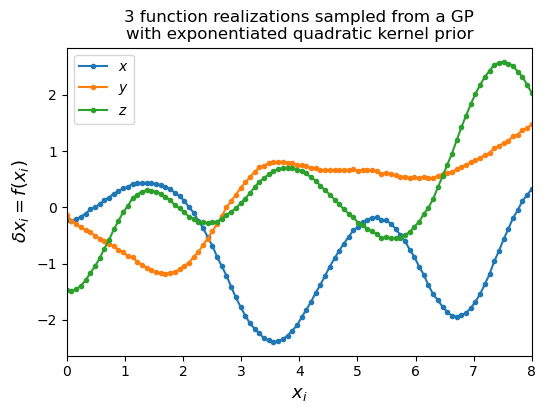

In [5]:
# Plot the sampled functions
labels = ['$x$', '$y$', '$z$']
plt.figure(figsize=(6, 4))
for i in range(number_of_functions):
    plt.plot(X, Y[i], linestyle='-', marker='o', markersize=3, label=labels[i])
plt.xlabel('$x_i$', fontsize=13)
plt.ylabel('$\delta x_{i} = f(x_i)$', fontsize=13)
plt.title((
    f'{number_of_functions} function realizations sampled from a GP\n'
    'with exponentiated quadratic kernel prior'))
plt.xlim([-0, 8])
plt.legend()
plt.show()

We want to efficiently generate a function that predicts the trajectory of the object. We will focus on the true trajectory of coordinate $x$ and try to fit a gaussian process on its underline function using random samples from the true data. In other words, we want to estimate the blue line on the graph using as few samples as possible.

### Fitting a Gaussian Proccess

The function to fit the Gaussian Process is provided. We now sample 5 random datapoints from the true trajectory and fit our model. In the graph we see the posterior mean prediction of the underline function $f$ and its 95% confidence interval.

In [6]:
def plot_model(model, x, y, Xsamples, Ysamples, Xplot):
    f_mean, f_var = model.predict_f(x)
    f_lower = f_mean - 1.96 * np.sqrt(f_var)
    f_upper = f_mean + 1.96 * np.sqrt(f_var)

    plt.plot(x, y, "-k", mew=2,  label="true dynamics")
    plt.plot(Xsamples, Ysamples, "r.", mew=2, label="input samples", zorder=10)
    plt.plot(Xplot, f_mean, "-", color="C0", label="posterior mean")
    plt.plot(Xplot, f_lower, "--", color="C0", label="95% confidence")
    plt.plot(Xplot, f_upper, "--", color="C0")
    plt.fill_between(
        Xplot[:, 0], f_lower[:, 0], f_upper[:, 0], color="C0", alpha=0.2
    )
    plt.xlabel("$x$")
    plt.ylabel("$f(x)$")
    plt.title(f"Posterior distribution of GP using {len(Xsamples)} data points")
    plt.legend()
    plt.show()

In [7]:
def _use_sampled_points(Xcopy, Ycopy, Xsampled_data, Ysampled_data, indices):
    Xsamples = Xcopy[indices]
    Ysamples = Ycopy[indices]
    Xcopy = np.delete(Xcopy, indices, axis=0)
    Ycopy = np.delete(Ycopy, indices, axis=0)
    Xsampled_data = np.concatenate((Xsampled_data, Xsamples), axis=0)
    Ysampled_data = np.concatenate((Ysampled_data, Ysamples), axis=0)
    return Xcopy, Ycopy, Xsampled_data, Ysampled_data

def fit_GP_model(X, Y):
    model = gpflow.models.GPR(
        (X, Y),
        kernel=gpflow.kernels.SquaredExponential(),
    )
    opt = gpflow.optimizers.Scipy()
    opt.minimize(model.training_loss, model.trainable_variables)
    return model

2024-03-27 14:12:45.317712: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-27 14:12:45.320999: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


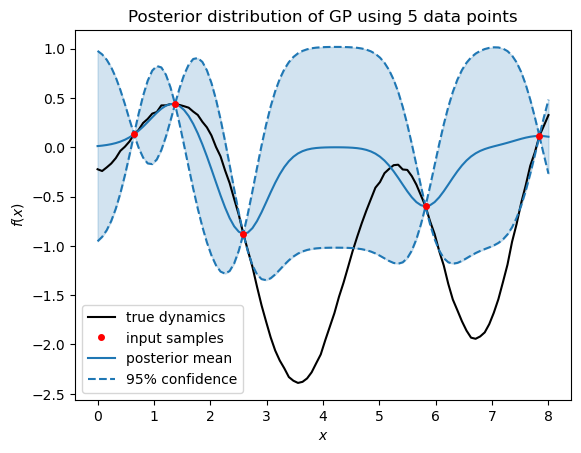

In [8]:
random.seed(1)
tol = 1e-4
print_freq = 5

Xsampled_data, Ysampled_data = np.zeros((0,1)), np.zeros((0,1))
Xcopy = copy.deepcopy(X)
Ycopy = copy.deepcopy(Y[:1].T)

start_samples = random.sample(range(len(Xcopy)), 5)
Xcopy, Ycopy, Xsampled_data, Ysampled_data = _use_sampled_points(Xcopy, Ycopy, Xsampled_data, Ysampled_data, start_samples)

model = fit_GP_model(Xsampled_data, Ysampled_data)

Xplot = np.linspace(0, 8, 100)[:, None]
plot_model(model, X, Y[:1].T, Xsampled_data, Ysampled_data, Xplot)

It is obvious that 5 data points are not enough to model the Gaussian Process sufficiently. We will keep sampling random points until we reach a satisfying fit of the GP. That means that we will keep estimating the GP with a new extra sample everytime until we reach convergence.

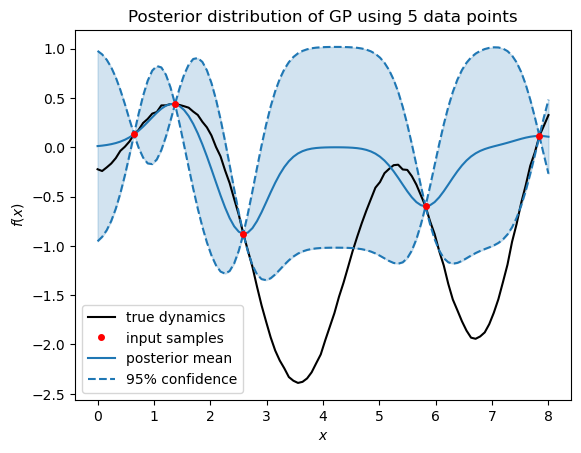

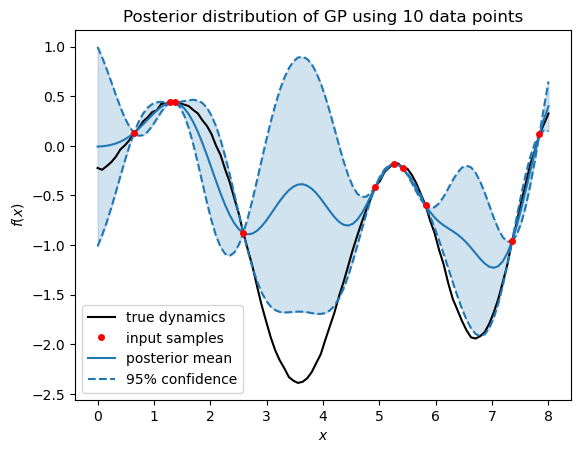

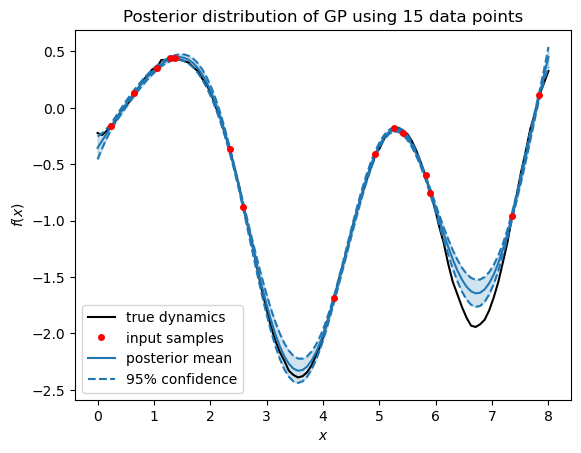

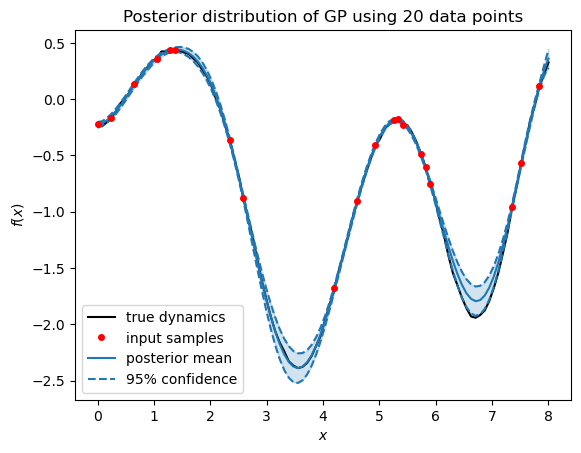

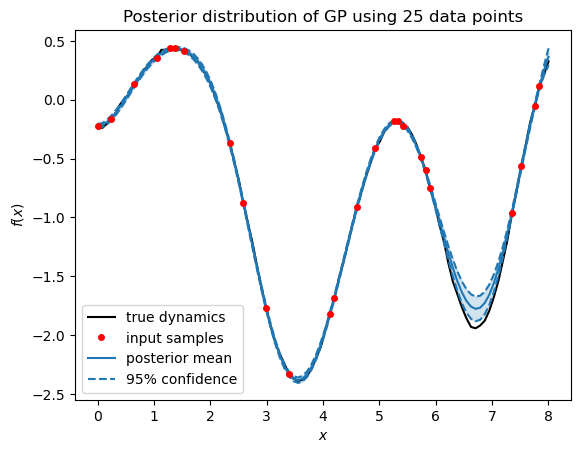

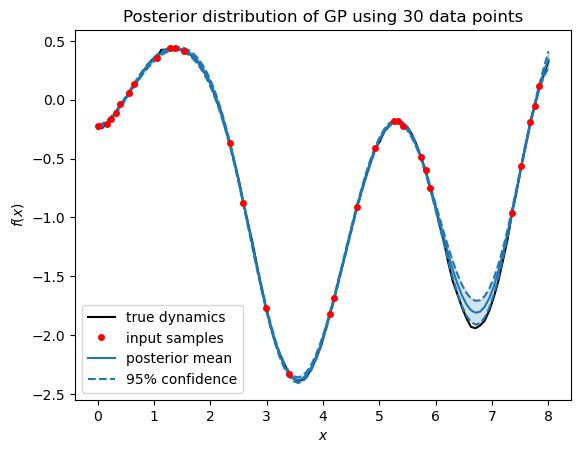

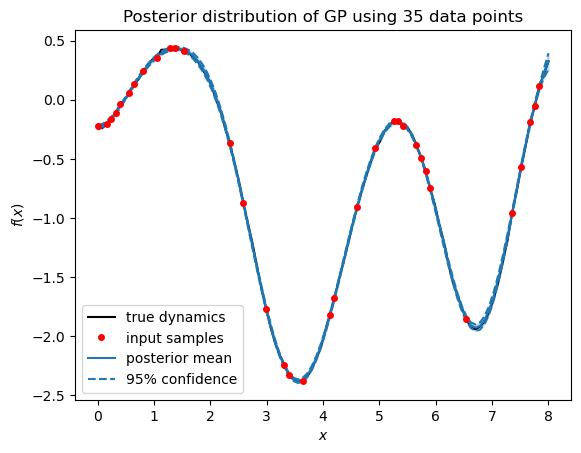

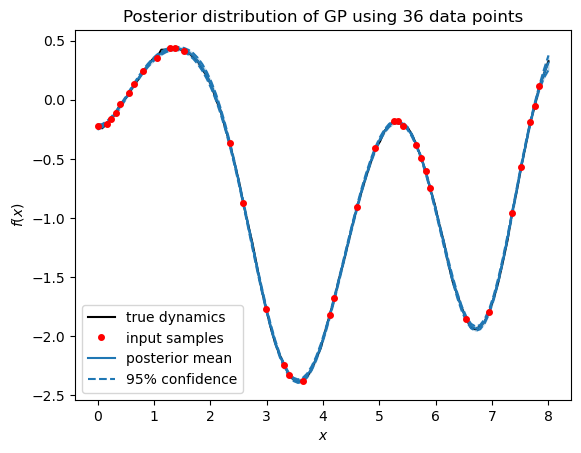

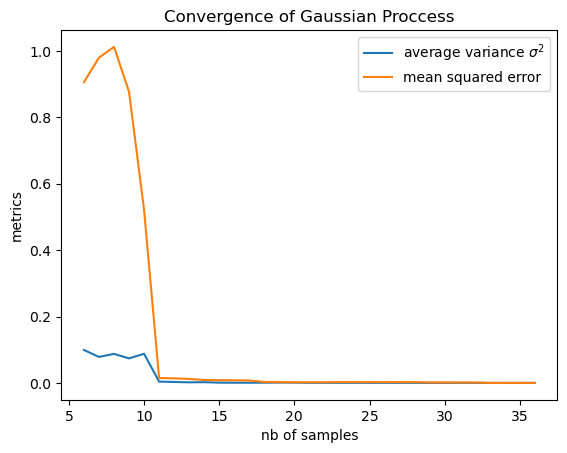

In [33]:
random.seed(1)

samples, var, loss = [], [], []
Xsampled_data, Ysampled_data = np.zeros((0,1)), np.zeros((0,1))
Xcopy = copy.deepcopy(X)
Ycopy = copy.deepcopy(Y[:1].T)

start_samples = random.sample(range(len(Xcopy)), 5)
Xcopy, Ycopy, Xsampled_data, Ysampled_data = _use_sampled_points(Xcopy, Ycopy, Xsampled_data, Ysampled_data, start_samples)

model = fit_GP_model(Xsampled_data, Ysampled_data)
plot_model(model, X, Y[:1,:].T, Xsampled_data, Ysampled_data, Xplot)

for i in range(6, 41, 1):
    nb_of_samples = i-len(Xsampled_data)
    index = random.sample(range(len(Xcopy)), nb_of_samples)
    
    Xcopy, Ycopy, Xsampled_data, Ysampled_data = _use_sampled_points(Xcopy, Ycopy, Xsampled_data, Ysampled_data, index)

    model = fit_GP_model(Xsampled_data, Ysampled_data)
    
    if i%print_freq==0:
        # Evaluation
        plot_model(model, X, Y[:1,:].T, Xsampled_data, Ysampled_data, Xplot)
    
    mean, variance = model.predict_f(Xplot)
    mse = np.sum(np.square(Y[0] - mean[:,0])) / Y[0].size
    
    samples.append(i)
    var.append(np.mean(variance))
    loss.append(mse)

    if (np.mean(variance) <= tol): break

plot_model(model, X, Y[:1,:].T, Xsampled_data, Ysampled_data, Xplot)

plt.plot(samples, var, label='average variance $\sigma^2$')
plt.plot(samples, loss, label='mean squared error')
plt.xlabel("nb of samples")
plt.ylabel("metrics")
plt.title('Convergence of Gaussian Proccess')
plt.legend()
plt.show()

Using a naive random sampling technique to acquire new data points results in convergence of the GP after 36 samples. If you mess with the random.seed() value you will see that this strategy is very unreliable. 

Generally 36 samples is not a lot but the function we try to model is not very complex and this number will scale really fast in real-world problems like modeling an actual physical system. The main point is you can do a lot better!

## Questions:
1. Random sampling according to which distribution is more likely to make the GP converge faster? Justify your opinion.
2. Propose a more sophisticated technique to sample new points. Which metric from Information Theory would you use?
    - Provide the mathematical formulation.
    - Write the code to calculate it for every point in a discrete set in $\mathbb{R}^n$.
    - Rerun the code with this technique and check if the GP converges faster. Explain why!
3. Suppose you have a distribution of points in $\mathbb{R^n}$ and you want to quantify the uncertainty of the GP on this whole space. Provide the mathematical formulation.

### Your turn!

Your answears here!

In [34]:
def compute_information_theory_metric(model, Xtest):
    """
    Calculate the appropriate metric from Information Theory
    :param model: Gaussian Process model already fitted on sampled data
    :param Xtest: remaining data that you can sample from, evaluate on those for easier indexing
                Normally we should use something like np.linspace(0, 8, 100) to evaluate our metric on,
                as in reality we would sample random points in space to evaluate our metric,
                but assume a discrete case for this exercise.
    """
    ######
    # TODO ON YOUR OWN
    metric = np.zeros(len(Xtest))
    ######
    return metric

In [35]:
def choose_next_sample(model, Xcopy):
    """
    Choose the best next point for your GP
    :param model: Gaussian Process model already fitted on sampled data
    :param Xcopy: remaining data that you can sample from, evaluate on those for easier indexing
    :returns int: index of Xcopy to use as next sampled point
    """
    metric = compute_information_theory_metric(model, Xcopy)
    return np.argmax(metric) #greedy approach

In [ ]:
random.seed(1)

Xsampled_data, Ysampled_data = np.zeros((0,1)), np.zeros((0,1))
samples, var, loss, it_metric = [], [], [], []
Xcopy = copy.deepcopy(X)
Ycopy = copy.deepcopy(Y[:1].T)

start_samples = random.sample(range(len(Xcopy)), 5)
Xcopy, Ycopy, Xsampled_data, Ysampled_data = _use_sampled_points(Xcopy, Ycopy, Xsampled_data, Ysampled_data, start_samples)

model = fit_GP_model(Xsampled_data, Ysampled_data)
plot_model(model, X, Y[:1,:].T, Xsampled_data, Ysampled_data, Xplot)

for i in range(6, 41, 1):
    nb_of_samples = i-len(Xsampled_data)
    index = [choose_next_sample(model, Xcopy)]
    
    Xcopy, Ycopy, Xsampled_data, Ysampled_data = _use_sampled_points(Xcopy, Ycopy, Xsampled_data, Ysampled_data, index)
    
    model = fit_GP_model(Xsampled_data, Ysampled_data)
    
    if i%print_freq==0:
        # Evaluation
        plot_model(model, X, Y[:1,:].T, Xsampled_data, Ysampled_data, Xplot)
    
    mean, variance = model.predict_f(Xplot)
    mse = np.sum(np.square(Y[0] - mean[:,0])) / Y[0].size
    
    metric = compute_information_theory_metric(model, Xplot)
    if i%print_freq==0:
        plt.plot(Xplot, metric)
        plt.title(f'Representation of the metric after {len(Xsampled_data)} samples')
        plt.xlabel('$t$')
        plt.ylabel('metric')
        plt.show()

    samples.append(i)
    var.append(np.mean(variance))
    loss.append(mse)
    it_metric.append(np.mean(metric))

    if (np.mean(variance) <= tol): break

plot_model(model, X, Y[:1,:].T, Xsampled_data, Ysampled_data, Xplot)

plt.plot(samples, var, label='average variance $\sigma^2$')
plt.plot(samples, loss, label='mean squared error')
plt.plot(samples, it_metric, label='information theory metric')
plt.xlabel("nb of samples")
plt.ylabel("metrics")
plt.title('Convergence of Gaussian Proccess')
plt.legend()
plt.show()